In [1]:
from os.path import join
import sys

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import seaborn as sns
from skimage.measure import regionprops

sys.path.append(r".")
from spideymaps_read import *
from spideymaps_calculation import *
from spideymaps_rendering import *

# Load data

In [2]:
folder = r"T:\MIGRATED\Lab_Members\Lauren_McCarthy\Data\Center_Microscope\RNAP\W3110\Exp\cwx2695\Compilation_230211_13"

labels_list, locs_list = read_map_data(
    labels_folders=[folder],
    locs_folders=[folder],
    labels_pattern="_PhaseMask.mat",
    locs_pattern="_AccBGSUB_fits_fits.csv",
    labels_format="smalllabs", # alternative "cellpose"
    locs_format="csv", # alternative "smalllabs"
    pixel_size=1, # for conversion if units are not pixels
    coord_cols=["row", "col"] # if using csv, specify which columns contain coordinates
    )

# Define grid

In [8]:
pixel_size = 0.049

vertebrae_frac_pos = np.arange(1/24, 0.99, 1/24) # how to divide cell along long axis in non-polar region
rings_frac_pos = np.arange(1/6, 0.99, 1/6) # how to divide cell radially
angles = [np.array([np.pi/2]), # what angles to sample in polar region, innermost ring to outermost
        np.array([np.pi/4, np.pi/2]),
        np.array([np.pi/6, np.pi/3, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),
        np.array([np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]),]
radius = 0.5 / pixel_size # used to decide where to transition from polar to non-polar, um / (um/px)

grid_params = {
                'vertebrae_frac_pos': vertebrae_frac_pos,
                'rings_frac_pos': rings_frac_pos,
                'angles': angles,
                'radius': radius,
               }

# Calculate for individual cells

In [9]:
cell_maps, cell_bools = calc_cell_maps(labels_list, locs_list, grid_params) # slowest part

Could not compute adaptive grid for cell # 2


# Generate representative cell

In [10]:
model_cell_bool = calc_model_cell(cell_bools)
model_cell = get_cell_grid(model_cell_bool, 
                           grid_params['vertebrae_frac_pos'],
                           grid_params['rings_frac_pos'],
                           grid_params['angles'], 
                           grid_params['radius'],
                           sigma_spine=1.5,
                           sigma_skin=2)

# Sum cells, symmetrify, and normalize

In [11]:
counts_total = sum_cell_maps(cell_maps, val_key='counts')
areas_total  = sum_cell_maps(cell_maps, val_key='areas')
counts_per_area = divide_dicts(counts_total, areas_total)
sym_elements = symmetric_grid_elements(model_cell["polygons"])
cpa_normed = normalize_map(counts_per_area, weights=areas_total)
cpa_norm_sym = average_sym_elements(cpa_normed, sym_elements)

# Render

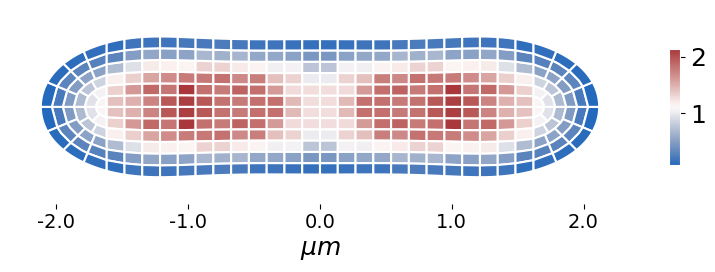

In [12]:
vabs = np.abs(np.array(list(cpa_normed.values()))-1).max()
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1-vabs, vmax=1+vabs)
# render_map(model_cell["polygons"], cpa_norm_sym, vmin=1.5, vmax=1.9)
render_map(model_cell["polygons"], cpa_norm_sym)

''

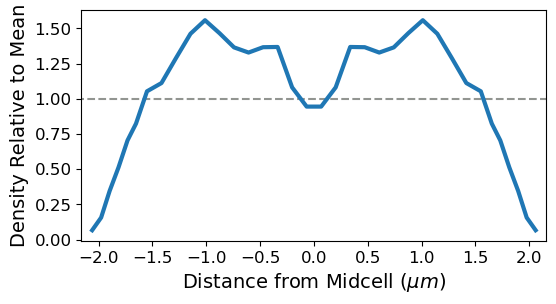

In [25]:
vals, pos = get_long_axis_vals(cpa_norm_sym, model_cell["polygons"])
pos_centered = pos - np.median(pos)

plt.figure(figsize=(6,3))
plt.plot([-3, 3], [1, 1], '--', color='xkcd:gray')

plt.plot(pos_centered*pixel_size, vals/vals.mean(), '-', lw=3)

# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=12, frameon=False)
plt.xlim([pos_centered[0]*pixel_size - 0.1,
          pos_centered[-1]*pixel_size + 0.1])

plt.xlabel(r'Distance from Midcell ($\mu m$)', fontsize=14)
plt.ylabel('Density Relative to Mean', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
;